In [ ]:
# !pip install tensorflow


In [1]:
import sys
from pathlib import Path

# Zum übergeordneten Ordner 'src' wechseln
current_path = Path().resolve()
src_path = current_path.parents[2]  # Zwei Stufen nach oben

if str(src_path) not in sys.path:
    sys.path.append(str(src_path))

src_path


WindowsPath('C:/Users/Nasiba/Documents/1 Master Data Science/Projektpraktikum/WebScience24')

In [2]:


import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from pathlib import Path
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

from collections import Counter
#nlp = spacy.load("en_core_web_sm")
from nltk import word_tokenize
pd.set_option('display.max_colwidth', None)
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from vector_functions import vectorize_word2vec, vectorize_glove, vectorize_glove_no_avarage, vectorize_word2vec_no_average
import nltk

import os
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense,Dropout
from tensorflow.keras.utils import to_categorical



#### Beladung der Daten

In [3]:

source_filepath_name = os.path.abspath(os.path.join(src_path, 'data/new_datasets/train_cleaned.csv'))

df_cleaned = pd.read_csv(source_filepath_name, encoding='utf-8', index_col=0)
df_cleaned.head(1)

,tweet,label,tweet_cleaned,user_handle,hashtags,emojis
154771,I love that you enjoy being trans.,0,love enjoy tran,0,[],NaN


### Vektorisierung

#### GloVe 

In [5]:


twitter_glove_path = os.path.abspath(os.path.join(src_path, 'src/3. Deep Learning Approach/nasiba/glove.twitter.27B.100d.txt'))


X_train_vectors_wht_av, X_test_vectors_wht_av, y_train_wht_av, y_test_wht_av, glove_embeddings_wht_av = vectorize_glove_no_avarage(df=df_cleaned, text_column ="tweet_cleaned", label_column="label", glove_path=twitter_glove_path)


X_train_vectors_wht_av.size



c:\Users\Nasiba\Documents\1 Master Data Science\Projektpraktikum\WebScience24\src\3. Deep Learning Approach\nasiba\vector_functions.py:346: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[text_column] = df[text_column].astype(str)


214395000

### Reshaping für LSTM

In [6]:
print(X_train_vectors_wht_av.shape)
print(X_test_vectors_wht_av.shape)


(42879, 50, 100)
(18378, 50, 100)


### Modell aufbauen 

#### Vektoren ohne Durchschnitt

##### Die Modelleingaben überprüfen

In [7]:
samples, max_seq_len, vector_size = X_train_vectors_wht_av.shape
num_classes = len(np.unique(y_train_wht_av))
print(samples)
print(max_seq_len)
print(vector_size)
print(num_classes)
print(X_test_vectors_wht_av.shape)
print(len(np.unique(y_test_wht_av)))

42879
50
100
2
(18378, 50, 100)
2


#### One-Hot-Encoding der Labels

In [8]:

y_train_onehot = to_categorical(y_train_wht_av, num_classes=num_classes)
y_test_onehot = to_categorical(y_test_wht_av, num_classes=num_classes)
print(y_train_onehot)
print(y_test_onehot)

[[1. 0.]
 [1. 0.]
 [1. 0.]
 ...
 [0. 1.]
 [1. 0.]
 [1. 0.]]
[[1. 0.]
 [0. 1.]
 [1. 0.]
 ...
 [1. 0.]
 [1. 0.]
 [1. 0.]]


##### Modellinitialisierung

In [9]:

# Modellinitialisierung
model = Sequential()

# LSTM-Schicht
model.add(LSTM(units=128, input_shape=(max_seq_len, vector_size), return_sequences=False))

# Optional: Dropout zur Vermeidung von Overfitting
model.add(Dropout(0.5))

# Dense-Schicht für die Ausgabe
model.add(Dense(units=num_classes, activation='softmax'))

# Kompilieren des Modells
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


C:\Users\Nasiba\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


#####  Modell trainieren

In [10]:

history = model.fit(
    X_train_vectors_wht_av, y_train_onehot,
    validation_data=(X_test_vectors_wht_av, y_test_onehot),
    epochs=10,
    batch_size=32,
    verbose=1
)

Epoch 1/10
1340/1340 ━━━━━━━━━━━━━━━━━━━━ 61s 44ms/step - accuracy: 0.7847 - loss: 0.4877 - val_accuracy: 0.8123 - val_loss: 0.4331
Epoch 2/10
1340/1340 ━━━━━━━━━━━━━━━━━━━━ 52s 39ms/step - accuracy: 0.8170 - loss: 0.4221 - val_accuracy: 0.8182 - val_loss: 0.4203
Epoch 3/10
1340/1340 ━━━━━━━━━━━━━━━━━━━━ 52s 39ms/step - accuracy: 0.8203 - loss: 0.4158 - val_accuracy: 0.8251 - val_loss: 0.4136
Epoch 4/10
1340/1340 ━━━━━━━━━━━━━━━━━━━━ 61s 45ms/step - accuracy: 0.8277 - loss: 0.4018 - val_accuracy: 0.8198 - val_loss: 0.4135
Epoch 5/10
1340/1340 ━━━━━━━━━━━━━━━━━━━━ 57s 42ms/step - accuracy: 0.8347 - loss: 0.3856 - val_accuracy: 0.8259 - val_loss: 0.4056
Epoch 6/10
1340/1340 ━━━━━━━━━━━━━━━━━━━━ 59s 44ms/step - accuracy: 0.8407 - loss: 0.3683 - val_accuracy: 0.8259 - val_loss: 0.4116
Epoch 7/10
1340/1340 ━━━━━━━━━━━━━━━━━━━━ 56s 42ms/step - accuracy: 0.8531 - loss: 0.3459 - val_accuracy: 0.8235 - val_loss: 0.4108
Epoch 8/10
1340/1340 ━━━━━━━━━━━━━━━━━━━━ 54s 40ms/step - accuracy: 0.8610 -

### Modell bewerten

In [11]:

# Testgenauigkeit
test_loss, test_accuracy = model.evaluate(X_test_vectors_wht_av, y_test_onehot)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")


575/575 ━━━━━━━━━━━━━━━━━━━━ 9s 16ms/step - accuracy: 0.8200 - loss: 0.4748
Test Loss: 0.4815741181373596
Test Accuracy: 0.8166829943656921


### Vorhersagen treffen

In [12]:
# Vorhersagen auf Testdaten
predictions = model.predict(X_test_vectors_wht_av)
predicted_classes = np.argmax(predictions, axis=1)

# Beispiel: Erste 5 Vorhersagen anzeigen
print("Predicted classes:", predicted_classes[:50])
print("Actual classes:", np.argmax(y_test_onehot[:50], axis=1))




575/575 ━━━━━━━━━━━━━━━━━━━━ 9s 15ms/step
Predicted classes: [0 1 0 0 0 0 0 1 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0 1 0 1
 0 1 0 0 0 1 0 1 0 1 0 0 1]
Actual classes: [0 1 0 0 0 1 1 0 1 0 0 1 0 0 1 0 0 0 1 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 1
 0 1 0 0 0 1 0 1 0 0 0 0 1]


In [13]:


# Klassifikationsbericht erstellen
report = classification_report(np.argmax(y_test_onehot, axis=1), predicted_classes, target_names=["Class 0", "Class 1"])
print("Classification Report:\n", report)


Classification Report:
               precision    recall  f1-score   support

     Class 0       0.86      0.92      0.89     14459
     Class 1       0.60      0.43      0.50      3919

    accuracy                           0.82     18378
   macro avg       0.73      0.68      0.69     18378
weighted avg       0.80      0.82      0.81     18378



[[13323  1136]
 [ 2233  1686]]


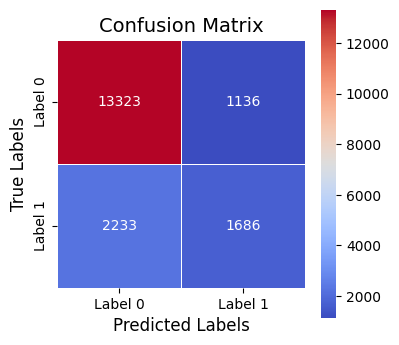

In [14]:
cm = confusion_matrix(np.argmax(y_test_onehot, axis=1), predicted_classes)
print(cm)
# Verwirrungsmatrix visualisieren
plt.figure(figsize=(4, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="coolwarm", linewidths=0.5, square=True,
            xticklabels=["Label 0", "Label 1"], yticklabels=["Label 0", "Label 1"])
plt.xlabel("Predicted Labels", fontsize=12)
plt.ylabel("True Labels", fontsize=12)
plt.title("Confusion Matrix", fontsize=14)
plt.show()

#### Vektor word2w

In [15]:

X_train_w2v, X_test_w2v, y_train_wv, y_test_vw, w2v_model = vectorize_word2vec_no_average(df=df_cleaned, text_column ="tweet_cleaned", label_column="label")

print("Erste Trainingsvektoren:")
print(X_train_w2v[:2])

c:\Users\Nasiba\Documents\1 Master Data Science\Projektpraktikum\WebScience24\src\3. Deep Learning Approach\nasiba\vector_functions.py:162: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[text_column] = df[text_column].astype(str)


Erste Trainingsvektoren:
[[[-0.11348205  0.36566114  0.00880749 ... -0.27172488  0.16991934
   -0.05486571]
  [-0.14173029 -0.05297533  1.04747391 ...  0.04249794 -0.29208022
   -0.10314114]
  [-0.08210145  0.16762406  0.02604158 ... -0.14933264  0.0327308
   -0.01689536]
  ...
  [ 0.          0.          0.         ...  0.          0.
    0.        ]
  [ 0.          0.          0.         ...  0.          0.
    0.        ]
  [ 0.          0.          0.         ...  0.          0.
    0.        ]]

 [[-0.44070634  0.82856691  0.11500658 ... -0.33559823 -0.14303596
    0.04560377]
  [-0.56132358  1.22684419 -0.06460174 ... -0.65937412  0.30283418
   -0.17192642]
  [-0.72283864  1.40432501  0.11439303 ... -0.58395308  0.04599426
   -0.11721717]
  ...
  [ 0.          0.          0.         ...  0.          0.
    0.        ]
  [ 0.          0.          0.         ...  0.          0.
    0.        ]
  [ 0.          0.          0.         ...  0.          0.
    0.        ]]]


In [16]:
print(X_train_w2v.shape)
print(X_test_w2v.shape)


(42879, 50, 100)
(18378, 50, 100)


In [17]:

samples,max_seq_len, vector_size = X_train_w2v.shape
num_classes = len(np.unique(y_train_wv))
print(samples)
print(max_seq_len)
print(vector_size)
print(num_classes)
print(X_test_w2v.shape)
print(len(np.unique(y_test_vw)))

42879
50
100
2
(18378, 50, 100)
2


In [18]:

y_train_onehot = to_categorical(y_train_wv, num_classes=num_classes)
y_test_onehot = to_categorical(y_test_vw, num_classes=num_classes)
print(y_train_onehot)
print(y_test_onehot)

[[1. 0.]
 [1. 0.]
 [1. 0.]
 ...
 [0. 1.]
 [1. 0.]
 [1. 0.]]
[[1. 0.]
 [0. 1.]
 [1. 0.]
 ...
 [1. 0.]
 [1. 0.]
 [1. 0.]]


In [19]:

# Modellinitialisierung
model = Sequential()

# LSTM-Schicht
model.add(LSTM(units=128, input_shape=(max_seq_len, vector_size), return_sequences=False))

# Optional: Dropout zur Vermeidung von Overfitting
model.add(Dropout(0.5))

# Dense-Schicht für die Ausgabe
model.add(Dense(units=num_classes, activation='softmax'))

# Kompilieren des Modells
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


C:\Users\Nasiba\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [20]:

history = model.fit(
    X_train_w2v, y_train_onehot,
    validation_data=(X_test_w2v, y_test_onehot),
    epochs=10,
    batch_size=32,
    verbose=1
)

Epoch 1/10
1340/1340 ━━━━━━━━━━━━━━━━━━━━ 54s 39ms/step - accuracy: 0.7832 - loss: 0.5163 - val_accuracy: 0.7985 - val_loss: 0.4650
Epoch 2/10
1340/1340 ━━━━━━━━━━━━━━━━━━━━ 50s 37ms/step - accuracy: 0.7944 - loss: 0.4694 - val_accuracy: 0.8040 - val_loss: 0.4503
Epoch 3/10
1340/1340 ━━━━━━━━━━━━━━━━━━━━ 52s 38ms/step - accuracy: 0.8039 - loss: 0.4484 - val_accuracy: 0.8122 - val_loss: 0.4359
Epoch 4/10
1340/1340 ━━━━━━━━━━━━━━━━━━━━ 49s 36ms/step - accuracy: 0.8091 - loss: 0.4378 - val_accuracy: 0.8115 - val_loss: 0.4401
Epoch 5/10
1340/1340 ━━━━━━━━━━━━━━━━━━━━ 49s 37ms/step - accuracy: 0.8118 - loss: 0.4390 - val_accuracy: 0.8150 - val_loss: 0.4317
Epoch 6/10
1340/1340 ━━━━━━━━━━━━━━━━━━━━ 367s 274ms/step - accuracy: 0.8176 - loss: 0.4276 - val_accuracy: 0.8168 - val_loss: 0.4242
Epoch 7/10
1340/1340 ━━━━━━━━━━━━━━━━━━━━ 52s 39ms/step - accuracy: 0.8193 - loss: 0.4222 - val_accuracy: 0.8183 - val_loss: 0.4291
Epoch 8/10
1340/1340 ━━━━━━━━━━━━━━━━━━━━ 53s 40ms/step - accuracy: 0.8203

In [21]:

# Testgenauigkeit
test_loss, test_accuracy = model.evaluate(X_test_w2v, y_test_onehot)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")


575/575 ━━━━━━━━━━━━━━━━━━━━ 9s 16ms/step - accuracy: 0.8212 - loss: 0.4327
Test Loss: 0.4320219159126282
Test Accuracy: 0.8204919099807739


In [22]:
# Vorhersagen auf Testdaten
predictions = model.predict(X_test_w2v)
predicted_classes = np.argmax(predictions, axis=1)

# Beispiel: Erste 5 Vorhersagen anzeigen
print("Predicted classes:", predicted_classes[:50])
print("Actual classes:", np.argmax(y_test_onehot[:50], axis=1))




575/575 ━━━━━━━━━━━━━━━━━━━━ 9s 15ms/step
Predicted classes: [0 1 0 0 0 0 0 1 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 1]
Actual classes: [0 1 0 0 0 1 1 0 1 0 0 1 0 0 1 0 0 0 1 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 1
 0 1 0 0 0 1 0 1 0 0 0 0 1]


In [23]:


# Klassifikationsbericht erstellen
report = classification_report(np.argmax(y_test_onehot, axis=1), predicted_classes, target_names=["Class 0", "Class 1"])
print("Classification Report:\n", report)


Classification Report:
               precision    recall  f1-score   support

     Class 0       0.85      0.94      0.89     14459
     Class 1       0.64      0.37      0.46      3919

    accuracy                           0.82     18378
   macro avg       0.74      0.65      0.68     18378
weighted avg       0.80      0.82      0.80     18378



[[13648   811]
 [ 2488  1431]]


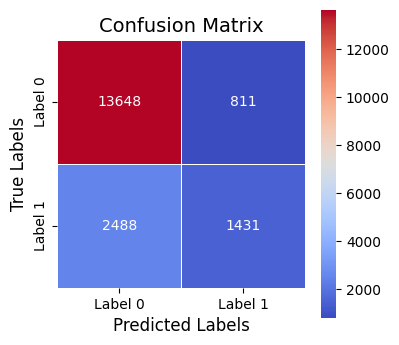

In [24]:
cm = confusion_matrix(np.argmax(y_test_onehot, axis=1), predicted_classes)
print(cm)
# Verwirrungsmatrix visualisieren
plt.figure(figsize=(4, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="coolwarm", linewidths=0.5, square=True,
            xticklabels=["Label 0", "Label 1"], yticklabels=["Label 0", "Label 1"])
plt.xlabel("Predicted Labels", fontsize=12)
plt.ylabel("True Labels", fontsize=12)
plt.title("Confusion Matrix", fontsize=14)
plt.show()